### Work version

In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional

from typing_extensions import Literal

from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
import requests
from striprtf.striprtf import rtf_to_text

load_dotenv()
# Set your OpenAI API key here
api_key = os.getenv("OPENAI_API_KEY")

# Initialize our LLM
# model = ChatOpenAI(model="gpt-4o", temperature=0)

In [10]:
general_prompt = """
Ти крутий дата аналітик
<Task>
Твоя робота використовувати інструменти які тобі доступні для відповіді на питання користувача.
Сьогодні питання наступне: {question}
Ти можеш використовувати тільки надані тобі для цього інструменти, що дозволить тобі правильно формувати відповідь для користувача.

<Available Tools>
Ти маєш доступ до наступних інструментів:
list_schemas	Lists all database schemas available in the PostgreSQL instance.
list_objects	Lists database objects (tables, views, sequences, extensions) within a specified schema.
get_object_details	Provides information about a specific database object, for example, a table's columns, constraints, and indexes.
execute_sql	Executes SQL statements on the database, with read-only limitations when connected in restricted mode.
explain_query	Gets the execution plan for a SQL query describing how PostgreSQL will process it and exposing the query planner's cost model. Can be invoked with hypothetical indexes to simulate the behavior after adding indexes.
get_top_queries	Reports the slowest SQL queries based on total execution time using pg_stat_statements data.
analyze_workload_indexes	Analyzes the database workload to identify resource-intensive queries, then recommends optimal indexes for them.
analyze_query_indexes	Analyzes a list of specific SQL queries (up to 10) and recommends optimal indexes for them.
analyze_db_health	Performs comprehensive health checks including: buffer cache hit rates, connection health, constraint validation, index health (duplicate/unused/invalid), sequence limits, and vacuum health.
extract_rtf_text Extracts and returns plain text from RTF content.
</Available Tools>

<Instructions>
Думай як справжній дата аналітик, який має задачу та лімітований час для її виконання.
Слідуй за наступним планом дій:
1. Прочитай запит користувача - Яку специфічну інформацію він хоче отримати?
2. Визнач які інструменти тобі потрібні для відповіді на це питання.
3. Використовуй інструменти по черзі, щоб отримати необхідні дані.
4. Якщо потрібно, аналізуй отримані дані, щоб сформувати відповідь.
5. Сформуй чітку та зрозумілу відповідь для користувача на основі отриманих даних.
</Instructions>
<Hard Limits>
**Tool Call Budgets** (Prevent excessive searching):
- **Simple queries**: Use 2-3 search tool calls maximum
- **Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find the right sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant examples/sources for the question
- Your last 2 searches returned similar information
</Hard Limits>

<Show Your Thinking>
After each search tool call, use think_tool to analyze the results:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?
</Show Your Thinking>
</Task>
"""

In [53]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse" 
    }
}

_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client

model = ChatOpenAI(model="gpt-4o", temperature=0)


class AgentState(TypedDict):
    url: Optional[str]
    messages: Annotated[list[AnyMessage], add_messages]
    raw_text: str
    summary:str


async def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text



async def summarize_text(text: str) -> str:
    """
    Generate a short Ukrainian summary for the given text using an LLM model.
    """


    summarization_prompt = PromptTemplate.from_template(
        """Summarize the following text in one short sentence. Summarize to ukrainian.
        
        Text: {text}
        
        Summary:"""
    )

    chain = summarization_prompt | model

    response = chain.invoke({"text": text}).content

    return response



async def llm_call(state: AgentState):
    """Analyze current state and decide on tool usage with MCP integration.

    This node:
    1. Retrieves available tools from MCP server
    2. Binds tools to the language model
    3. Processes user input and decides on tool usage

    Returns updated state with model response.
    """
    # Get available tools from MCP server
    client = get_mcp_client()
    mcp_tools = await client.get_tools()

    # Use MCP tools for local document access
    tools = mcp_tools# + [extract_rtf_text, summarize_text]

    # Initialize model with tool binding
    model_with_tools = model.bind_tools(tools)

    # Process user input with system prompt
    return {
        "messages": [
            model_with_tools.invoke(
                [SystemMessage(content=general_prompt)] + state["messages"]
            )
        ]
    }


In [52]:
async def tool_node(state: AgentState):
    """Execute tool calls using MCP tools.

    This node:
    1. Retrieves current tool calls from the last message
    2. Executes all tool calls using async operations (required for MCP)
    3. Returns formatted tool results

    Note: MCP requires async operations due to inter-process communication
    with the MCP server subprocess. This is unavoidable.
    """
    tool_calls = state["messages"][-1].tool_calls

    async def execute_tools():
        """Execute all tool calls. MCP tools require async execution."""
        # Get fresh tool references from MCP server
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = mcp_tools#  + [extract_rtf_text, summarize_text]
        tools_by_name = {tool.name: tool for tool in tools}

        # Execute tool calls (sequentially for reliability)
        observations = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            if tool_call["name"] == "think_tool":
                # think_tool is sync, use regular invoke
                observation = tool.invoke(tool_call["args"])
            else:
                # MCP tools are async, use ainvoke
                observation = await tool.ainvoke(tool_call["args"])
            observations.append(observation)

        # Format results as tool messages
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"messages": messages}

In [47]:
def compress_research(state: AgentState) -> dict:
    """Compress research findings into a concise summary.

    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for further processing or reporting.

    This function filters out think_tool calls and focuses on substantive
    file-based research content from MCP tools.
    """
    
    system_message = "Summarize all information"
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", [])

    response = model.invoke(messages)

    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["messages"], 
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

In [54]:
def should_continue(state: AgentState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue with tool execution or compress research.

    Determines whether to continue with tool execution or compress research
    based on whether the LLM made tool calls.
    """
    messages = state["messages"]
    last_message = messages[-1]

    # Continue to tool execution if tools were called
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, compress research findings
    return "compress_research"

In [55]:
# Build the agent workflow
agent_builder_mcp = StateGraph(AgentState)

# Add nodes to the graph
agent_builder_mcp.add_node("llm_call", llm_call)
agent_builder_mcp.add_node("tool_node", tool_node)
agent_builder_mcp.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder_mcp.add_edge(START, "llm_call")
agent_builder_mcp.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",        # Continue to tool execution
        "compress_research": "compress_research",  # Compress research findings
    },
)
agent_builder_mcp.add_edge("tool_node", "llm_call")  # Loop back for more processing
agent_builder_mcp.add_edge("compress_research", END)

# Compile the agent
agent_mcp = agent_builder_mcp.compile()

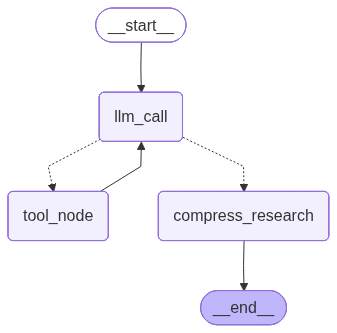

In [56]:
from IPython.display import Image, display

# Show the agent
display(Image(agent_mcp.get_graph(xray=True).draw_mermaid_png()))

In [57]:
b = "скільки записів є по справі 136/1512/24"

result = await agent_mcp.ainvoke({"messages": [HumanMessage(content=f"{b}.")]})

In [58]:
result

{'messages': [HumanMessage(content='скільки записів є по справі 136/1512/24.', additional_kwargs={}, response_metadata={}, id='64ae7a93-bd4b-4600-9e25-f533a2a40bf1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qw4DJVbQIfpBxbBL3vOifXa9', 'function': {'arguments': '{}', 'name': 'list_schemas'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1401, 'total_tokens': 1412, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-COTQmgZG7g6bol3QqfavaZiSG89DC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ed85e614-cbbb-45a4-bc03-7cae2381bf67-0', tool_calls=[{'name': 'list_schemas', 'args': {}, 'id': 'call_qw4DJVbQIfpBxbBL3

### Next good graph

In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional

from typing_extensions import Literal

from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
import requests
from striprtf.striprtf import rtf_to_text

load_dotenv()
# Set your OpenAI API key here
api_key = os.getenv("OPENAI_API_KEY")

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [4]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse" 
    }
}

_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


client = get_mcp_client()
mcp_tools = await client.get_tools()
# agent =  create_react_agent(model, mcp_tools)

In [7]:
async def call_model(state: AgentState):
    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (court cases) and run computations with provided tools
"""
    sys_msg = SystemMessage(content=prompt)
    response = model.bind_tools(mcp_tools).invoke([sys_msg]+state["messages"])
    return {"messages": response}

In [8]:
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_node(ToolNode(mcp_tools))
builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    tools_condition,
)
builder.add_edge("tools", "call_model")
graph = builder.compile()

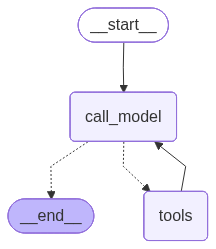

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
math_response = await graph.ainvoke({"messages": "скільки записів є по справі 136/1512/24?"})

In [24]:
q = """який результат виведе ця кверя select count(*) from documents d 
where 1 =1 
and cause_num = '136/1512/24'"""   

math_response = await graph.ainvoke({"messages": q})

In [26]:
q = """хто суддя по справі  '136/1512/24'"""   

math_response = await graph.ainvoke({"messages": q})

In [11]:
for m in math_response["messages"]:
    m.pretty_print()

================================ Human Message =================================

скільки записів є по справі 136/1512/24?
================================== Ai Message ==================================
Tool Calls:
  list_schemas (call_lcGztss5Xb8NR9RzeTH4Axv6)
 Call ID: call_lcGztss5Xb8NR9RzeTH4Axv6
  Args:
================================= Tool Message =================================
Name: list_schemas

[{'schema_name': 'information_schema', 'schema_owner': 'kaliani', 'schema_type': 'System Information Schema'}, {'schema_name': 'pg_catalog', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'pg_toast', 'schema_owner': 'kaliani', 'schema_type': 'System Schema'}, {'schema_name': 'public', 'schema_owner': 'pg_database_owner', 'schema_type': 'User Schema'}]
================================== Ai Message ==================================
Tool Calls:
  list_objects (call_vrjwUcNg1U1kKXQYywXlxNDi)
 Call ID: call_vrjwUcNg1U1kKXQYywXlxNDi
  Args:
    schema_name: 

In [16]:
q = """який результат виведе ця кверя select count(*) from documents d 
where 1 =1 
and cause_num = '136/1512/24'"""   

math_response = await agent.ainvoke({"messages": q})

In [17]:
math_response

{'messages': [HumanMessage(content="який результат виведе ця кверя select count(*) from documents d \nwhere 1 =1 \nand cause_num = '136/1512/24'", additional_kwargs={}, response_metadata={}, id='4c71b6b7-b528-47c8-b4d2-13cea141cc1f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NYDoFSiS8K6DDV3MVcWZH4hb', 'function': {'arguments': '{"sql":"select count(*) from documents d where 1 =1 and cause_num = \'136/1512/24\'","analyze":true}', 'name': 'explain_query'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 735, 'total_tokens': 777, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-COliQdJ3AlOjgIKWKGbD6CqASk4yl', 'service_tier': 'default', 'finish_reaso

### Mixed tools graph

In [1]:
import os
from dotenv import load_dotenv

from typing import TypedDict, List, Dict, Any, Optional

from typing_extensions import Literal

from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
import requests
from striprtf.striprtf import rtf_to_text

load_dotenv()
# Set your OpenAI API key here
api_key = os.getenv("OPENAI_API_KEY")

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [2]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from typing import List, TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse" 
    }
}

_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


client = get_mcp_client()
mcp_tools = await client.get_tools()
agent =  create_react_agent(model, mcp_tools)

In [3]:
from langchain_core.tools import tool

@tool
def extract_rtf_text(url: str) -> str:
    """
    Download an RTF document from the given URL and extract plain text from it.
    """
    response = requests.get(url)
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [5]:
async def call_model(state: AgentState):
    prompt = f"""
    You are a helpful assistant. You can analyse summarize texts (court cases) and run computations with provided tools
"""
    sys_msg = SystemMessage(content=prompt)
    response = model.bind_tools(mcp_tools).invoke([sys_msg]+state["messages"])
    return {"messages": response}

In [6]:
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(MessagesState)
builder.add_node(call_model)
builder.add_node(ToolNode(mcp_tools))
builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    tools_condition,
)
builder.add_edge("tools", "call_model")
graph = builder.compile()

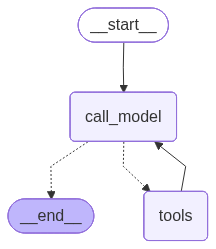

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
mcp_tools

[StructuredTool(name='list_schemas', description='List all schemas in the database', args_schema={'properties': {}, 'title': 'list_schemasArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000017CFFBD74C0>),
 StructuredTool(name='list_objects', description='List objects in a schema', args_schema={'properties': {'schema_name': {'description': 'Schema name', 'title': 'Schema Name', 'type': 'string'}, 'object_type': {'default': 'table', 'description': "Object type: 'table', 'view', 'sequence', or 'extension'", 'title': 'Object Type', 'type': 'string'}}, 'required': ['schema_name'], 'title': 'list_objectsArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000017CFFBD76A0>),
 StructuredTool(name='get_object_details', description='Show detailed information about a database object', args_schema={'

In [8]:
agent =  create_react_agent(model, mcp_tools)

In [9]:
math_response = await agent.ainvoke({"messages": "скільки записів є по справі 136/1512/24?"})

In [10]:
math_response = await graph.ainvoke({"messages": "скільки записів є по справі 136/1512/24?"})

In [16]:
math_response = await graph.ainvoke({"messages": "скільки записів є по справі 136/1512/24 в таблиці documents?"})

In [15]:
math_response = await graph.ainvoke({"messages": "скільки записів є по справі doc_id = 136/1512/24 в таблиці documents?"})

In [10]:
qq = """
знайди в таблиці documents doc_id 120887237 та 120879576
дістань url з doc_url поля і вивантаж ці тексти порівняй їх
і поясни в чому вони схожі 
"""

In [9]:
qq = """
find in table documents doc_id 120887237 
put url from field doc_url and download an RTF document from the given URL and extract plain text from it.
"""

In [11]:
math_response = await graph.ainvoke({"messages": qq})

In [27]:
for i in math_response['messages']:
    i.pretty_print()

================================ Human Message =================================


знайди в таблиці documents doc_id 120887237 та 120879576
дістань url з doc_url поля і вивантаж ці тексти порівняй їх
і поясни в чому вони схожі 

================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_IZ8pzpGWkPjzfHEDxNkx9LKl)
 Call ID: call_IZ8pzpGWkPjzfHEDxNkx9LKl
  Args:
    sql: SELECT doc_url FROM documents WHERE doc_id = 120887237;
  execute_sql (call_KSMK0eiQFcuYPLQZbp8vQZlS)
 Call ID: call_KSMK0eiQFcuYPLQZbp8vQZlS
  Args:
    sql: SELECT doc_url FROM documents WHERE doc_id = 120879576;
================================= Tool Message =================================
Name: execute_sql

[{'doc_url': 'http://od.reyestr.court.gov.ua/files/60/4f92f26de65a221c48b7c6f7d74ee9bc.rtf'}]
================================= Tool Message =================================
Name: execute_sql

[{'doc_url': 'http://od.reyestr.court.gov.ua/files/60/70528f94d4b8

###  Backlog

In [6]:
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse"   # зверни увагу на /sse
    }
}

async def run_agent():
        
        client = MultiServerMCPClient(mcp_config)

        async with client.session("postgres") as session:
              tools = await load_mcp_tools(session)
              model = ChatOpenAI(model="gpt-4o")
              agent = create_react_agent(model, tools)
              q = """який результат виведе ця кверя select count(*) from documents d 
where 1 =1 
and cause_num = '136/1512/24'"""    
              resp = await agent.ainvoke({"messages": q})
              print(resp)

result = await run_agent()

{'messages': [HumanMessage(content="який результат виведе ця кверя select count(*) from documents d \nwhere 1 =1 \nand cause_num = '136/1512/24'", additional_kwargs={}, response_metadata={}, id='07949526-b093-428a-9356-410f51e5c2f6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fKgLB72SjjNtWZE5E9P3nbaB', 'function': {'arguments': '{}', 'name': 'list_schemas'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 735, 'total_tokens': 746, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CMI6XU1y4sWY6dEmbaFHnRLDYvaJV', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c154742a-7981-4c7b-a143-029b2bc9445b-0', tool_calls=[{'

In [2]:
from typing import TypedDict, List
from langchain_mcp_adapters.client import MultiServerMCPClient

class AgentState(TypedDict):
    researcher_messages: str
    text: str
    summary: str
    url: str

In [3]:
_client = None

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse"  
    }
}

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client

In [4]:
model = ChatOpenAI(model="gpt-4.1", temperature=0)

In [7]:
async def extract_rtf_text(state: AgentState) :
    """
    Extract text from URL in RTF format.

    Args:
        url (str): The URL of the RTF document.

    Returns:
        str: The extracted plain text from the RTF document.
    """
    response = requests.get(state["url"])
    response.raise_for_status()

    rtf_content = response.content.decode("utf-8", errors="ignore")

    text = rtf_to_text(rtf_content)
    return text

In [14]:
client = get_mcp_client()
mcp_tools = await client.get_tools()
tools = mcp_tools + [extract_rtf_text]
model_with_tools = model.bind_tools(tools)

PydanticUserError: Please use `typing_extensions.TypedDict` instead of `typing.TypedDict` on Python < 3.12.

For further information visit https://errors.pydantic.dev/2.11/u/typed-dict-version

In [10]:
async def llm_call_router(state: AgentState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=general_prompt)] + state["researcher_messages"]
            )
        ]
    }

In [9]:
async def tool_node(state: AgentState):
    """Execute tool calls using MCP tools.

    This node:
    1. Retrieves current tool calls from the last message
    2. Executes all tool calls using async operations (required for MCP)
    3. Returns formatted tool results

    Note: MCP requires async operations due to inter-process communication
    with the MCP server subprocess. This is unavoidable.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls

    async def execute_tools():
        """Execute all tool calls. MCP tools require async execution."""
        # Get fresh tool references from MCP server
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = mcp_tools + [extract_rtf_text]
        tools_by_name = {tool.name: tool for tool in tools}

        # Execute tool calls (sequentially for reliability)
        observations = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            if tool_call["name"] == "think_tool":
                # think_tool is sync, use regular invoke
                observation = tool.invoke(tool_call["args"])
            else:
                # MCP tools are async, use ainvoke
                observation = await tool.ainvoke(tool_call["args"])
            observations.append(observation)

        # Format results as tool messages
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"researcher_messages": messages}

In [11]:
async def tool_node(state: AgentState):
    """Execute tool calls using MCP tools.

    This node:
    1. Retrieves current tool calls from the last message
    2. Executes all tool calls using async operations (required for MCP)
    3. Returns formatted tool results

    Note: MCP requires async operations due to inter-process communication
    with the MCP server subprocess. This is unavoidable.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls

    async def execute_tools():
        """Execute all tool calls. MCP tools require async execution."""
        # Get fresh tool references from MCP server
        client = get_mcp_client()
        mcp_tools = await client.get_tools()
        tools = mcp_tools + [extract_rtf_text]
        tools_by_name = {tool.name: tool for tool in tools}

        # Execute tool calls (sequentially for reliability)
        observations = []
        for tool_call in tool_calls:
            tool = tools_by_name[tool_call["name"]]
            if tool_call["name"] == "think_tool":
                # think_tool is sync, use regular invoke
                observation = tool.invoke(tool_call["args"])
            else:
                # MCP tools are async, use ainvoke
                observation = await tool.ainvoke(tool_call["args"])
            observations.append(observation)

        # Format results as tool messages
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"researcher_messages": messages}

In [8]:
def summarize(state: AgentState) -> dict:
    """
    Summarizes the given text using the LLM.
    
    Args:
        text (str): The text to summarize.

    Returns:
        str: The summary of the text.
    """
    summarization_prompt = PromptTemplate.from_template(
        """Summarize the following text in one short sentence. Summarize to ukrainian.
        
        Text: {text}
        
        Summary:"""
    )
    
    # Create a chain by connecting the prompt template to the language model
    # The "|" operator pipes the output of the prompt into the model
    chain = summarization_prompt | model
    
    # Execute the chain with the input text from the state dictionary
    # This passes the text to be summarized to the model
    response = chain.invoke({"text": state["text"]})
    
    # Return a dictionary with the summary extracted from the model's response
    # This will be merged into the agent's state
    return {"summary": response.content}


In [39]:

def should_continue(state: AgentState) -> Literal["tool_node", "summarize"]:
    """Determine whether to continue with tool execution or compress research.

    Determines whether to continue with tool execution or compress research
    based on whether the LLM made tool calls.
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # Continue to tool execution if tools were called
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, compress research findings
    return "summarize"

In [17]:
agent_builder_mcp = StateGraph(AgentState)

In [ ]:
# agent_builder_mcp.add_node("llm_call_router", llm_call_router)
# agent_builder_mcp.add_node("tool_node", tool_node)
# agent_builder_mcp.add_node("summarize", summarize)

# agent_builder_mcp.add_edge(START, "llm_call_router")
# agent_builder_mcp.add_conditional_edges(
#     "llm_call_router",
#     should_continue,
#     {
#         "tool_node": "tool_node",        # Continue to tool execution
#         "summarize": "summarize",  # Compress research findings
#     },
# )
# agent_builder_mcp.add_edge("tool_node", "llm_call_router")  # Loop back for more processing
# agent_builder_mcp.add_edge("summarize", END)

# # Compile the agent
# agent_mcp = agent_builder_mcp.compile()

In [18]:
agent_builder_mcp.add_node("llm_call_router", llm_call_router)
agent_builder_mcp.add_node("tool_node", tool_node)
agent_builder_mcp.add_node("summarize", summarize)

agent_builder_mcp.add_edge(START, "llm_call_router")
agent_builder_mcp.add_edge("llm_call_router", "tool_node")
agent_builder_mcp.add_edge("tool_node", "summarize")
agent_builder_mcp.add_edge("summarize", END)
agent_mcp = agent_builder_mcp.compile()

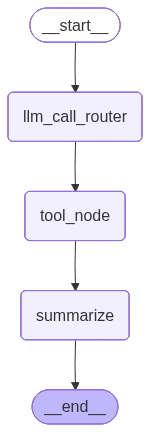

In [19]:
from IPython.display import Image, display

display(Image(agent_mcp.get_graph(xray=True).draw_mermaid_png()))

In [20]:
qq = "хто суддя в doc_id 120879625?"

result = await agent_mcp.ainvoke({"researcher_messages": [HumanMessage(content=f"{qq}.")]})
result['researcher_messages']

AttributeError: 'function' object has no attribute 'name'

In [2]:
# !pip install langchain-mcp-adapters

In [2]:
from langchain_mcp_adapters.client import MultiServerMCPClient

# 'stdio', 'sse', 'websocket', 'streamable_http'.

mcp_config = {
    "postgres": {
        "transport": "sse",
        "url": "http://127.0.0.1:8000/sse"   # зверни увагу на /sse
    }
}

client = MultiServerMCPClient(mcp_config)
tools = await client.get_tools()

In [3]:
llm = model.bind_tools(tools)

In [8]:
llm.invoke("""
які поля є в таблиці documents?       
""")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xf87VnMSNWzejOl9mYsXCA4y', 'function': {'arguments': '{}', 'name': 'list_schemas'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 711, 'total_tokens': 722, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CMFWe9BfOTVHmKL8DvjT6qdtX8yW4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--acc63b7c-3c63-485a-95ad-efcacb9fd1cc-0', tool_calls=[{'name': 'list_schemas', 'args': {}, 'id': 'call_Xf87VnMSNWzejOl9mYsXCA4y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 711, 'output_tokens': 11, 'total_tokens': 722, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outp

In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient


client = MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            # Replace with absolute path to your math_server.py file
            "args": ["E:\vibe-judges\notebooks\math.py"],
            "transport": "stdio",
        }
    }
)

tools = await client.get_tools()
print("finish")

UnsupportedOperation: fileno

In [ ]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [21]:
for tool in tools:
    print(tool.description)
    # print(tool.description[:77] + "..." if len(tool.description) > 80 else tool.description)

List all schemas in the database
List objects in a schema
Show detailed information about a database object
Explains the execution plan for a SQL query, showing how the database will execute it and provides detailed cost estimates.
Analyze frequently executed queries in the database and recommend optimal indexes
Analyze a list of (up to 10) SQL queries and recommend optimal indexes
Analyzes database health. Here are the available health checks:
- index - checks for invalid, duplicate, and bloated indexes
- connection - checks the number of connection and their utilization
- vacuum - checks vacuum health for transaction id wraparound
- sequence - checks sequences at risk of exceeding their maximum value
- replication - checks replication health including lag and slots
- buffer - checks for buffer cache hit rates for indexes and tables
- constraint - checks for invalid constraints
- all - runs all checks
You can optionally specify a single health check or a comma-separated list of health

In [5]:
from langchain.agents import AgentExecutor, create_react_agent

In [3]:
from langchain_core.prompts import PromptTemplate

template = '''Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}'''

prompt = PromptTemplate.from_template(template)

In [6]:
llm = model.bind_tools(tools)

agent = create_react_agent(llm, tools, prompt)


agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)

In [9]:
await agent_executor.ainvoke({"input": "виведи всі таблиці які існуюють в базі?"})

{'input': 'виведи всі таблиці які існуюють в базі?',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [8]:
x

{'input': 'виведи всі таблиці які існуюють в базі?',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [19]:
text = "пошукай скільки документів по справі 136/1512/24"

agent = create_react_agent(model, 
                           tools, 
                           prompt)

In [20]:
math_response  = await agent.ainvoke(
    {"messages": [{"role": "user", "content": "які є поля в таблиці documents?"}]}
)

KeyError: 'intermediate_steps'

In [17]:
agent.ainvoke(
    {"messages": [{"role": "user", "content": "які є поля в таблиці documents?"}]}
)

<coroutine object RunnableSequence.ainvoke at 0x0000018E3B5DD900>

In [13]:
agent = create_react_agent("openai:gpt-4.1", tools)
math_response = await agent.ainvoke({"messages": "what's (3 + 5) x 12?"})

TypeError: 'coroutine' object is not subscriptable

In [11]:
from mcp.server.fastmcp import FastMCP

mcp = FastMCP("Math")

@mcp.tool()
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@mcp.tool()
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

if __name__ == "__main__":
    mcp.run(transport="stdio")

RuntimeError: Already running asyncio in this thread